### What I really need to test here is how CAMB is computing the power spectrum
#### How are the parameters interpreted when I feed them in, what is the sigma 8 value, how does changing the input change the output

In [1]:
%matplotlib inline
import os
import sys
import numpy as np
from astropy.io import fits as pf
from sklearn.neighbors import KernelDensity as kde
from scipy import integrate
import camb
from camb import model
from scipy.special import j0
from scipy import interpolate
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D as ax3d
from skmonaco import mcquad
from skmonaco import mcmiser
import time

In [2]:
#Import SpIES / SHELA data
data = '../Data_Sets/QSO_Candidates_allcuts_with_errors_visualinsp.fits'
obs = pf.open(data)[1].data
Z = obs.zphotNW
gdx = ((Z >= 2.9)&(Z <= 5.2) & (obs.Good_obj == 0))
#gdx = Z>0
#Set up a KDE for dNdz
tmpz = Z[gdx][:, np.newaxis] #change the array from row shape (1) to column shape (1,)
print np.shape(tmpz)
sample_range = np.linspace(min(tmpz[:, 0]), max(tmpz[:, 0]), len(tmpz[:, 0]))[:, np.newaxis]
est = kde(bandwidth=0.1,kernel='gaussian') #Set up the Kernel
histkde = est.fit(tmpz).score_samples(sample_range) #fit the kernel to the data and find the density of the grid
#Interpolate (you get the same function back) to plug in any z in the range (as opposed to set z values)
dNdz = interpolate.interp1d(sample_range.flatten(),np.exp(histkde))
print sample_range.flatten()
print 'done'

IOError: [Errno 2] No such file or directory: '../Data_Sets/QSO_Candidates_allcuts_with_errors_visualinsp.fits'

In [3]:
#Plot the KDE dndz
plt.plot(sample_range[:,0],np.exp(histkde))
plt.xlabel('z')
#plt.plot(sample_range[:,0],dNdz(sample_range[:,0]))
#plt.plot(bins[:-1],num,linestyle = 'steps-mid')
ZE = np.linspace(min(Z),max(Z),100)
xo=integrate.quad(dNdz,min(sample_range),max(sample_range)) #quad(f(x),xlower,xupper, args)
print xo
#plt.savefig('dndz.png')
plt.show() 

NameError: name 'sample_range' is not defined

In [8]:
# Compute the matter power spectrum from CAMB and Generate the P(z,k) function to output the power at any given redshift
#and wavenumber

#First define Planck 2015 cosmological parameters
H = 70 #H0. 
oc = 0.229 #physical density of CDM 
ob = 0.046 #physical density of baryons

#Conversion to density param: Omega_Matter = (oc+ob)/(H0/100.)**2

#Set up parameters in CAMB
pars = camb.CAMBparams()
#H0 is hubble parameter at z=0, ombh2 is the baryon density (physical), omch2 is the matter density (physical)
#mnu is sum of neutrino masses, omk is curvature parameter (set to 0 for flat), meffsterile is effective mass of sterile neutrinos
#pars.set_cosmology(H0=H,ombh2=ob, omch2=oc,omk=0)#,mnu=0,meffsterile=0) 

pars.H0=H
pars.omegab=ob
pars.omegac=oc
pars.omegav=0.725
pars.set_dark_energy()

#Set parameters using standard power law parameterization.If nt=None, uses inflation consistency relation.
#ns is scalar speectral index
pars.InitPower.set_params(ns=0.960)
camb.set_halofit_version(version='original') #uses the Smith 2003 halo model
ze=np.linspace(0,20,150)
ka=np.logspace(-4,1.5,len(ze))#np.linspace(0,10,100)
#Get the matter power spectrum interpolation object (based on RectBivariateSpline). 
#pars: input parameters, zs: redshift range, nonlinear: generate nonlinear power spectrum, hubble_units=True: output as Mpc/h^-3 
#instead of Mpc^-3 
PK = camb.get_matter_power_interpolator(pars,zs = ze,zmax = ze[-1], nonlinear=True, hubble_units=True, k_hunit=True, kmax = ka[-1])
#Generate the power using the interpolator and the z and k arrays
#Power = PK.P(z,k)

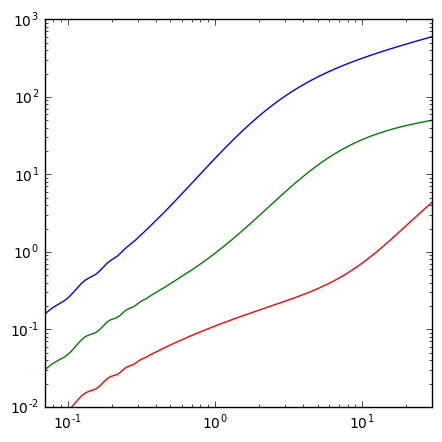

In [9]:
def dimpower(Pk,z,k):
    delta = Pk.P(z,k) * k**3/(2*np.pi**2)
    return delta

k=np.logspace(-3,2,1000)
#k=10**kay

plt.figure(2, figsize = (5,5))
plt.plot(k,dimpower(PK,0,k))
plt.plot(k,dimpower(PK,2,k))
plt.plot(k,dimpower(PK,6,k))
plt.xscale('log')
plt.yscale('log')
plt.ylim(10**-2,10**3)
plt.xlim(7*10**-2,3*10**1)

plt.show()

In [6]:
# Print the parameters out
pars2 = camb.CAMBparams()

#Not non-linear corrections couples to smaller scales than you want
pars2.set_matter_power(redshifts=[0., 1.0, 6.0], kmax=10.0)
H = 70 #H0. 
oc = 0.229 #physical density of CDM 
ob = 0.046 #physical density of baryons

#H0 is hubble parameter at z=0, ombh2 is the baryon density (physical), omch2 is the matter density (physical)
#mnu is sum of neutrino masses, omk is curvature parameter (set to 0 for flat), meffsterile is effective mass of sterile neutrinos
#pars.set_cosmology(H0=H,ombh2=ob, omch2=oc,omk=0)#,mnu=0,meffsterile=0) 

pars2.H0=H
pars2.omegab=ob
pars2.omegac=oc
pars2.omegav=0.725
pars2.set_dark_energy()

#Set parameters using standard power law parameterization.If nt=None, uses inflation consistency relation.
#ns is scalar speectral index
pars2.InitPower.set_params(As = 2e-9,ns=0.960)
'''
#Linear spectra
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)
kh, z, pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=10, npoints = 1000)
s8 = np.array(results.get_sigma8())
print s8
'''
#Non-Linear spectra (Halofit)
pars2.NonLinear = model.NonLinear_both
camb.set_halofit_version(version='original') #uses the Smith 2003 halo model
camb.get_transfer_functions(pars2)

results = camb.get_results(pars2)
results.calc_power_spectra(pars2)
kh_nonlin, z_nonlin, pk_nonlin = results.get_matter_power_spectrum(minkh=1e-4, maxkh=10, npoints = 1000)
s82 = np.array(results.get_sigma8())

print results.get_matter_transfer_data()


print s82
print ''

print z_nonlin
print np.shape(pk_nonlin)
print np.shape(kh_nonlin)


Note: redshifts have been re-sorted (earliest first)
[ 0.14463468  0.4800139   0.77303182]

[0.0, 1.0, 6.0]
(3, 1000)
(1000,)


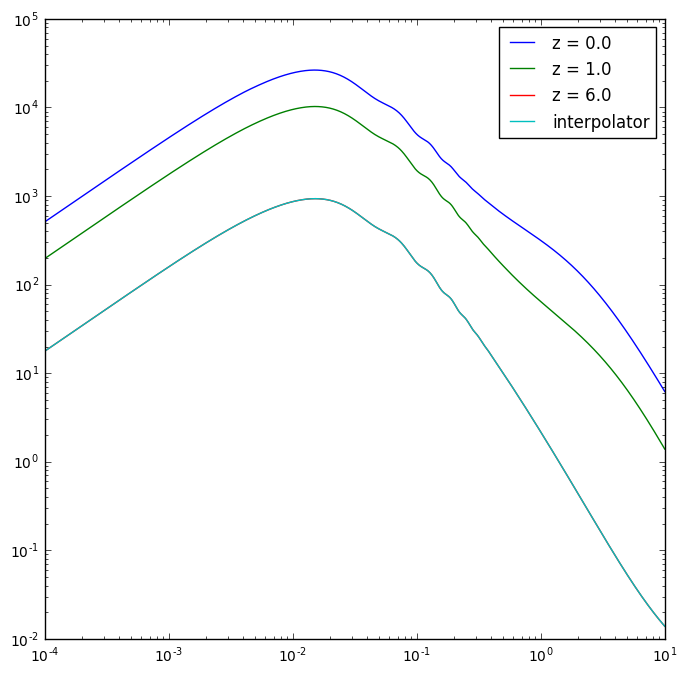

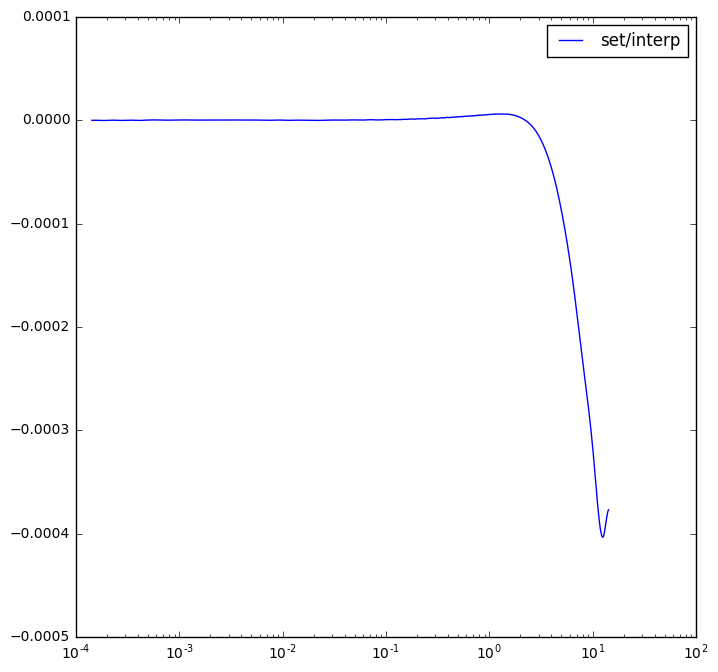

In [7]:
plt.figure(2,figsize = [8,8])

plt.plot(kh_nonlin,pk_nonlin[0],label='z = %s'%z_nonlin[0])
plt.plot(kh_nonlin,pk_nonlin[1],label='z = %s'%z_nonlin[1])
plt.plot(kh_nonlin,pk_nonlin[2],label='z = %s'%z_nonlin[2])
plt.plot(kh_nonlin,PK.P(z_nonlin[2],kh_nonlin),label='interpolator')

plt.xscale('log')
plt.yscale('log')

plt.legend()
plt.show()


plt.figure(3,figsize = [8,8])

#plt.plot(kh_nonlin,pk_nonlin[2],label='z = %s'%z_nonlin[2])
plt.plot(kh_nonlin/0.7,pk_nonlin[2]/PK.P(z_nonlin[2],kh_nonlin)-1,label='set/interp')

plt.xscale('log')
#plt.yscale('log')

plt.legend()
plt.show()

In [8]:
print results.get_params().InitPower.ScalarPowerAmp[0]


2e-09


In [9]:
# Print the parameters out
pars3 = camb.CAMBparams()

#Not non-linear corrections couples to smaller scales than you want
pars3.set_matter_power(redshifts=[0., 1.0, 6.0], kmax=10.0)
H = 70 #H0. 
oc = 0.229 #physical density of CDM 
ob = 0.046 #physical density of baryons

#H0 is hubble parameter at z=0, ombh2 is the baryon density (physical), omch2 is the matter density (physical)
#mnu is sum of neutrino masses, omk is curvature parameter (set to 0 for flat), meffsterile is effective mass of sterile neutrinos
#pars.set_cosmology(H0=H,ombh2=ob, omch2=oc,omk=0)#,mnu=0,meffsterile=0) 

pars3.H0=H
pars3.omegab=ob
pars3.omegac=oc
pars3.omegav=0.725
pars3.set_dark_energy()

#Set parameters using standard power law parameterization.If nt=None, uses inflation consistency relation.
#ns is scalar speectral index
sig8old = float(s82[-1])
print sig8old
pars3.InitPower.set_params(As = 2e-9*(0.8/sig8old)**2,ns=0.960)

#Non-Linear spectra (Halofit)
pars3.NonLinear = model.NonLinear_both
camb.set_halofit_version(version='original') #uses the Smith 2003 halo model
camb.get_transfer_functions(pars3)

results2 = camb.get_results(pars3)
results2.calc_power_spectra(pars3)
kh_nonlin, z_nonlin, pk_nonlin = results2.get_matter_power_spectrum(minkh=1e-4, maxkh=10, npoints = 1000)
s83 = np.array(results2.get_sigma8())

print results.get_matter_transfer_data()


print s83
print ''

print z_nonlin
print np.shape(pk_nonlin)
print np.shape(kh_nonlin)


Note: redshifts have been re-sorted (earliest first)
0.773031823703
[ 0.14968044  0.49675978  0.8       ]

[0.0, 1.0, 6.0]
(3, 1000)
(1000,)
